# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## План работы

1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона: <br>
 2.1 Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.<br>
 2.2. Обучите модель и сделайте предсказания на валидационной выборке.<br>
 2.3. Сохраните предсказания и правильные ответы на валидационной выборке.<br>
 2.4. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.<br>
 2.5. Проанализируйте результаты.<br>
3. Подготовьтесь к расчёту прибыли:<br>
 3.1. Все ключевые значения для расчётов сохраните в отдельных переменных.<br>
 3.2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. <br>
 3.3. Напишите выводы по этапу подготовки расчёта прибыли.<br>
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:<br>
 4.1. Выберите скважины с максимальными значениями предсказаний. <br>
 4.2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.<br>
 4.3. Рассчитайте прибыль для полученного объёма сырья.<br>
5. Посчитайте риски и прибыль для каждого региона:<br>
 5.1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.<br>
 5.2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.<br>
 5.3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.<br>

### Описание исходных данных

Данные геологоразведки трёх регионов находятся в файлах: <br>
/datasets/geo_data_0.csv.<br>
/datasets/geo_data_1.csv.<br>
/datasets/geo_data_2.csv.<br>
**id** — уникальный идентификатор скважины;<br>
**f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);<br>
**product** — объём запасов в скважине (тыс. баррелей).<br>

### Условия задачи

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).<br>
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.<br>
Бюджет на разработку скважин в регионе — 10 млрд рублей.<br>
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.<br>
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.<br>
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.<br>

## Загрузка и подготовка данных

### Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

seed=110923

### Загрузка и первичное изучение данных

In [2]:
geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [7]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [9]:
geo_data_0.duplicated().sum()

0

In [10]:
geo_data_1.duplicated().sum()

0

In [11]:
geo_data_2.duplicated().sum()

0

In [12]:
geo_data_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


**Вывод:** <br>
1. В полученных данных отсутствуют пропуски и дубликаты <br>
2. Столбец 'id' является статистически незначимой, и будет исключена.

C:\Users\user\AppData\Local\Temp\ipykernel_21640\1921754391.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(geo_data_0.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


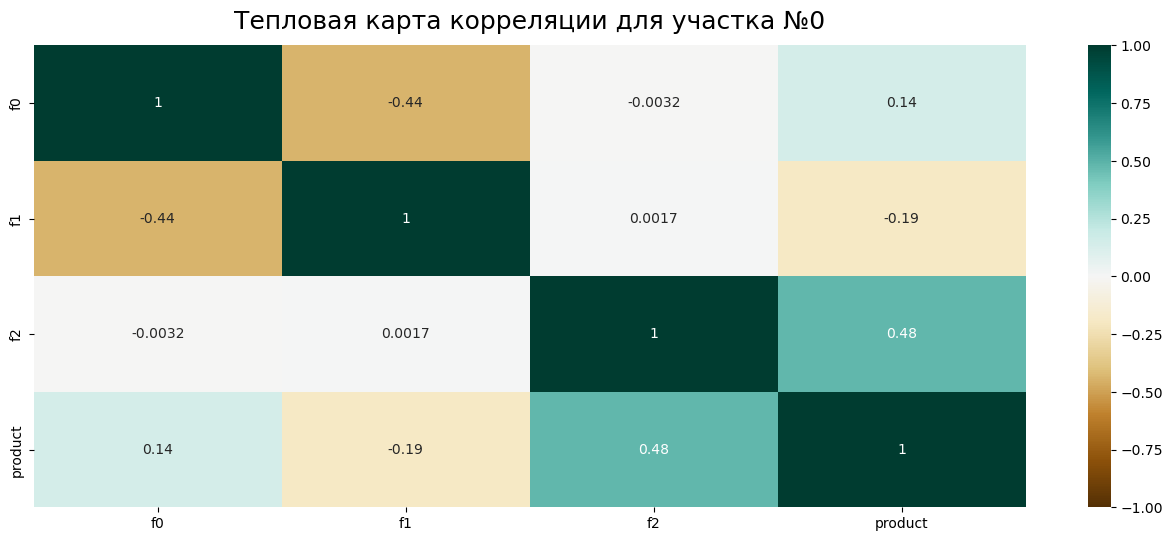

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(geo_data_0.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции для участка №0', fontdict={'fontsize':18}, pad=12); 

C:\Users\user\AppData\Local\Temp\ipykernel_21640\1932959662.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(geo_data_1.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


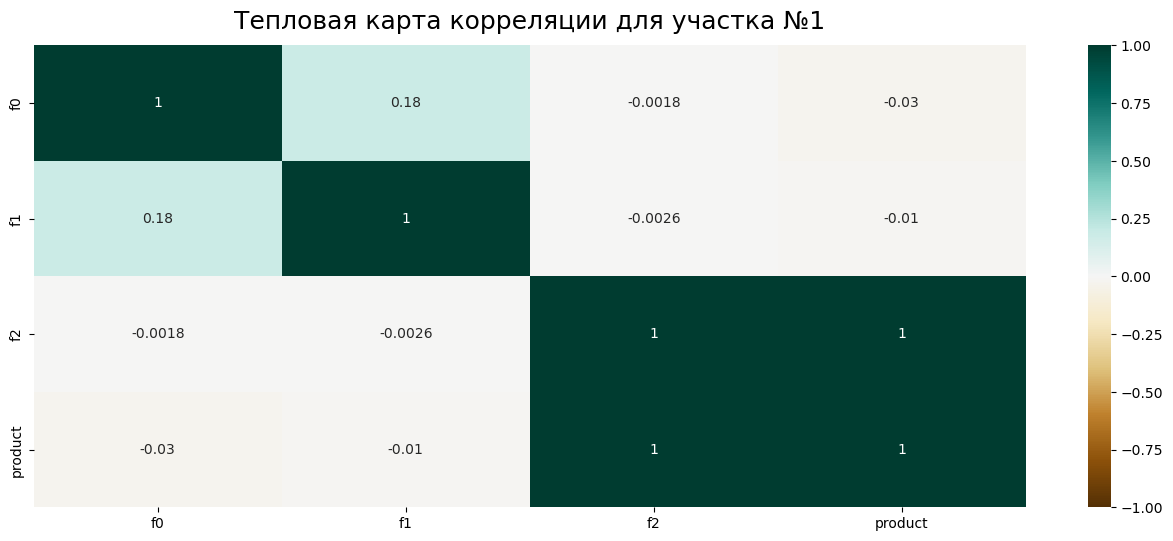

In [14]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(geo_data_1.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции для участка №1', fontdict={'fontsize':18}, pad=12); 

C:\Users\user\AppData\Local\Temp\ipykernel_21640\1259341683.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(geo_data_2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')


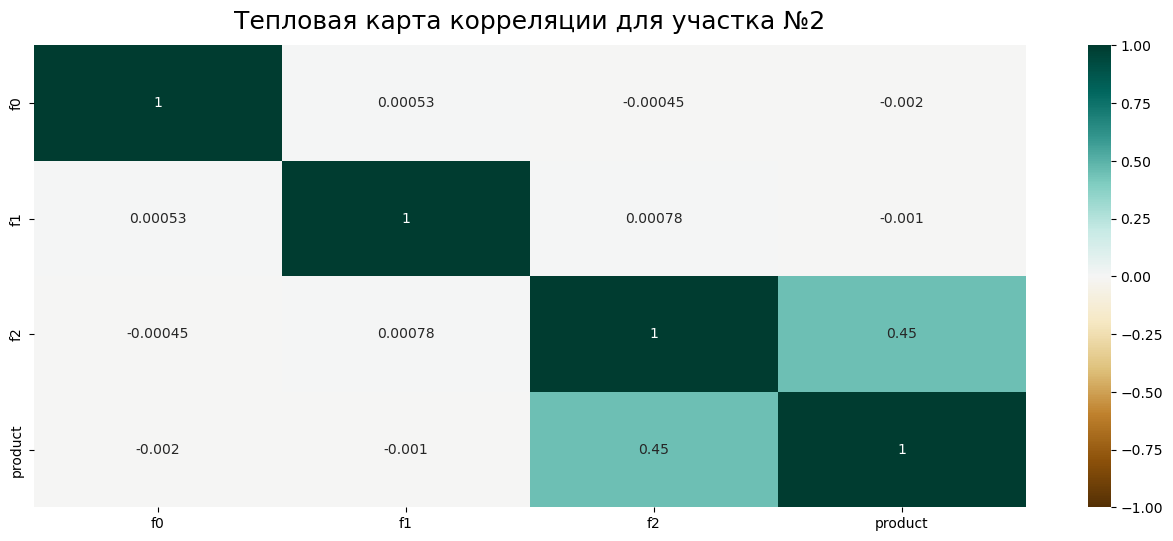

In [15]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(geo_data_2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Тепловая карта корреляции для участка №2', fontdict={'fontsize':18}, pad=12); 

Следует отметить, что участок №1 единственный имеет 100% корреляцию между параметрами f2 и product.

### Обработка данных и изучение графиков

В соответствии с выводом из прошлого этапа, исключаем id (уникальный идентификатор скважины) из данных. 

In [16]:
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

In [17]:
#fig_all_product = go.Figure()
#fig_all_product.add_trace(go.Histogram(x=geo_data_0['product'], opacity=0.75, name='Регион №1' ))
#fig_all_product.add_trace(go.Histogram(x=geo_data_1['product'], opacity=0.75, name='Регион №2'))
#fig_all_product.add_trace(go.Histogram(x=geo_data_2['product'], opacity=0.75, name='Регион №3'))
#fig_all_product.update_layout(
#    title="Сводная диаграмма по объему запасов в регионах №1-3",
#    xaxis_title="тыс. баррелей",
#    yaxis_title="количество скважин",
#    legend=dict(x=.5, xanchor="center", orientation="h"),
#    barmode='overlay',
#    margin=dict(l=0, r=0, t=30, b=0))
#fig_all_product.show()

In [18]:
# fig_all_f0 = go.Figure()
# fig_all_f0.add_trace(go.Histogram(x=geo_data_0['f0'], opacity=0.75, name='Регион №1'))
# fig_all_f0.add_trace(go.Histogram(x=geo_data_1['f0'], opacity=0.75, name='Регион №2'))
# fig_all_f0.add_trace(go.Histogram(x=geo_data_2['f0'], opacity=0.75, name='Регион №3'))
# fig_all_f0.update_layout(
#     title="Сводная диаграмма по параметру f0 в регионах №1-3",
#     xaxis_title="ед",
#     yaxis_title="количество скважин",
#     legend=dict(x=.5, xanchor="center", orientation="h"),
#     barmode='overlay',
#     margin=dict(l=0, r=0, t=30, b=0))
# fig_all_f0.show()

In [19]:
# fig_all_f1 = go.Figure()
# fig_all_f1.add_trace(go.Histogram(x=geo_data_0['f1'], opacity=0.75, name='Регион №1'))
# fig_all_f1.add_trace(go.Histogram(x=geo_data_1['f1'], opacity=0.75, name='Регион №2'))
# fig_all_f1.add_trace(go.Histogram(x=geo_data_2['f1'], opacity=0.75, name='Регион №3'))
# fig_all_f1.update_layout(
#     title="Сводная диаграмма по параметру f1 в регионах №1-3",
#     xaxis_title="ед",
#     yaxis_title="количество скважин",
#     legend=dict(x=.5, xanchor="center", orientation="h"),
#     barmode='overlay',
#     margin=dict(l=0, r=0, t=30, b=0))
# fig_all_f1.show()

In [20]:
# fig_all_f2 = go.Figure()
# fig_all_f2.add_trace(go.Histogram(x=geo_data_0['f2'], opacity=0.75, name='Регион №1'))
# fig_all_f2.add_trace(go.Histogram(x=geo_data_1['f2'], opacity=0.75, name='Регион №2'))
# fig_all_f2.add_trace(go.Histogram(x=geo_data_2['f2'], opacity=0.75, name='Регион №3'))
# fig_all_f2.update_layout(
#     title="Сводная диаграмма по параметру f2 в регионах №1-3",
#     xaxis_title="ед",
#     yaxis_title="количество скважин",
#     legend=dict(x=.5, xanchor="center", orientation="h"),
#     barmode='overlay',
#     margin=dict(l=0, r=0, t=30, b=0))
# fig_all_f2.show()

**Вывод:** <br>
Построены сводные гистраграммы по целевому признаку 'product', а также по признакам модели 'f1', 'f2', 'f3'. <br>
Регион №1 и Регион №3 имеют схожее распределение запасов нефти, в то время как как регион №2 имеет более выраженную консолидацию вокруг определенных значений. Форма распределения может быть обусловлена точностью применяемого оборудования, а также человеческим фактором (с т.з. приведение значений к какому-либо стандартному ряду), либо же синтезированными данными <br>

## Обучение и проверка модели

### Разбивка на выборки

In [21]:
def region_split(data, target):
    features = data.drop([target] , axis=1)
    target = data[target]

    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=seed)
    
    return features_train, features_valid, target_train, target_valid

In [22]:
features_train_reg_00, features_valid_reg_00, target_train_reg_00, target_valid_reg_00 = region_split(geo_data_0, 'product')
features_train_reg_00.head()

,f0,f1,f2
20974,1.622923,-0.514356,3.908372
88572,1.607610,-0.212164,2.149596
49499,1.492816,-0.392048,2.126638
46283,1.009458,0.285465,-2.168584
13244,1.504905,-0.233343,7.185273


In [23]:
features_train_reg_01, features_valid_reg_01, target_train_reg_01, target_valid_reg_01 = region_split(geo_data_1, 'product')
features_train_reg_01.head()

,f0,f1,f2
20974,-1.660801,1.928452,-0.000458
88572,-0.920804,-0.758156,5.007810
49499,-2.400142,-17.503340,5.002560
46283,8.169597,-12.207587,4.995762
13244,5.816181,-5.421094,1.009066


In [24]:
features_train_reg_02, features_valid_reg_02, target_train_reg_02, target_valid_reg_02 = region_split(geo_data_2, 'product')
features_train_reg_02.head()

,f0,f1,f2
20974,0.161282,-1.307232,2.841210
88572,3.747098,1.000670,-0.561570
49499,-1.567186,-1.426156,-3.824216
46283,0.009759,0.485688,1.334670
13244,0.171420,1.913346,-1.272516


### Обучение моделей

In [25]:
#модель для нулевого региона
model = LinearRegression()

model.fit(features_train_reg_00, target_train_reg_00)

predicted_reg_00 = model.predict(features_valid_reg_00)

mse_reg_00 = mean_squared_error(target_valid_reg_00, predicted_reg_00)
rmse_reg_00 = mse_reg_00**0.5
reg_00_mean = predicted_reg_00.mean()


In [26]:
#модель для первого региона
model = LinearRegression()

model.fit(features_train_reg_01, target_train_reg_01)

predicted_reg_01 = model.predict(features_valid_reg_01)

mse_reg_01 = mean_squared_error(target_valid_reg_01, predicted_reg_01)
rmse_reg_01 = mse_reg_01**0.5
reg_01_mean = predicted_reg_01.mean()


In [27]:
#модель для второго региона
model = LinearRegression()

model.fit(features_train_reg_02, target_train_reg_02)

predicted_reg_02 = model.predict(features_valid_reg_02)

mse_reg_02 = mean_squared_error(target_valid_reg_02, predicted_reg_02)
rmse_reg_02 = mse_reg_02**0.5
reg_02_mean = predicted_reg_02.mean()


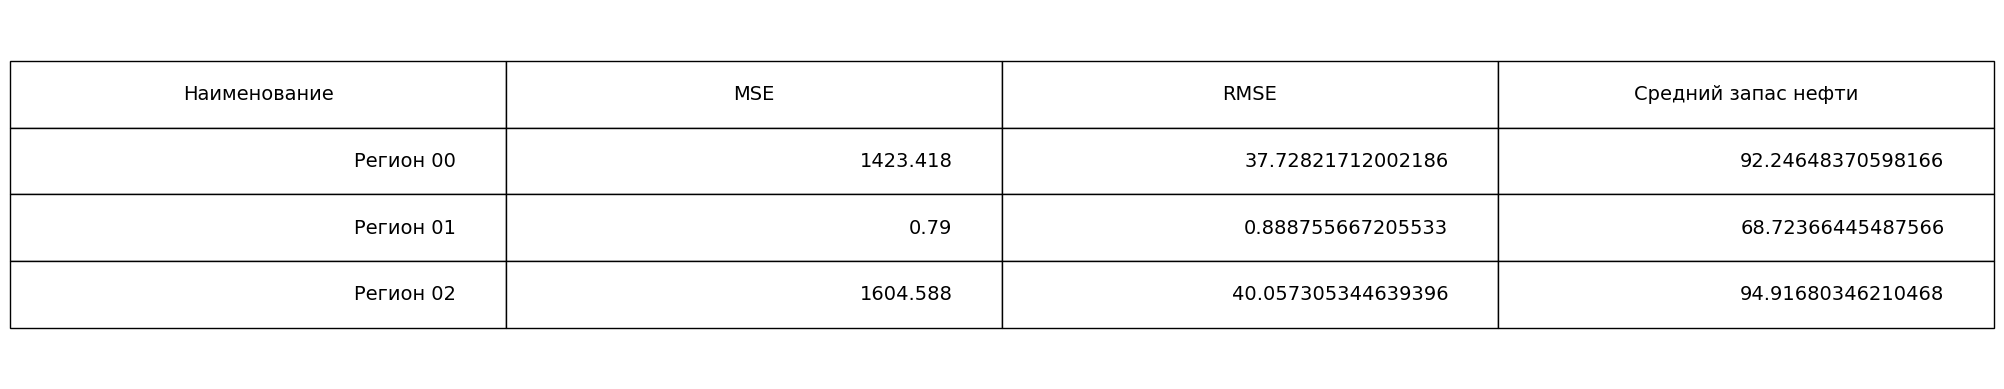

In [28]:
fig, ax = plt.subplots()


table_data=[
  ["Регион 00", round(mse_reg_00, 3), rmse_reg_00, reg_00_mean],
   ["Регион 01", round(mse_reg_01, 3), rmse_reg_01, reg_01_mean],
   ["Регион 02", round(mse_reg_02, 3), rmse_reg_02, reg_02_mean],
]



table = ax.table(cellText=table_data, loc='center',colLabels = ['Наименование', 'MSE', 'RMSE', 'Средний запас нефти'] )

table.set_fontsize (14)
table. scale (4,4)
ax.axis('off')

plt.show() 

Запишем полученные значения дополнительно для дальнейшей работы.

In [29]:
target_valid_reg_00 = pd.Series(target_valid_reg_00)
predicted_reg_00 = pd.Series (predicted_reg_00, index = target_valid_reg_00.index)
target_valid_reg_01 = pd.Series(target_valid_reg_01)
predicted_reg_01 = pd.Series (predicted_reg_01, index = target_valid_reg_01.index)
target_valid_reg_02 = pd.Series(target_valid_reg_02)
predicted_reg_02 = pd.Series (predicted_reg_02, index = target_valid_reg_02.index)

## Подготовка к расчёту прибыли

Повторим исходные данные, а также запишем в переменные основные показатели.<br>
При разведке региона исследуют **500 точек**, из которых с помощью машинного обучения выбирают **200 лучших** для разработки.<br>
Бюджет на разработку скважин в регионе — **10 млрд рублей**.<br>
При нынешних ценах один баррель сырья приносит **450 рублей дохода**. Доход с каждой единицы продукта составляет **450 тыс. рублей**, поскольку объём указан в тысячах баррелей.<br>
После оценки рисков нужно оставить лишь те регионы, **в которых вероятность убытков меньше 2.5%**. Среди них выбирают регион с наибольшей средней прибылью.<br>

In [30]:
ALL_POINTS = 500
BEST_POINTS = 200
BUDGET = 10e9
ONE_BARREL = 450
BARREL_PRICE = ONE_BARREL*1000


In [31]:
cvp = round(BUDGET  / (BARREL_PRICE * BEST_POINTS), 2)
print('Объем нефти для безубыточности составляет -',cvp, 'тыс. баррелей')

Объем нефти для безубыточности составляет - 111.11 тыс. баррелей


Таким образом, объем нефти для безубыточности превышает *средний* запас нефти по всем точкам в исследуемых регионах. <br>

Для расчета прибыли будем использовать функцию, которая сортирует полученные данные по предсказанному продукту, сортирует и принимает для расчета первые BEST_POINTS = 200 скважин. <br>
После чего, от общей стоимости добытой нефти в данных скважинах отнимает затраты на разработку скважин.

In [32]:
predictions_sorted = predicted_reg_00.sort_values(ascending=False).reset_index(drop = True)

In [33]:
print(predictions_sorted)

0        180.118355
1        176.181205
2        175.949787
3        175.834280
4        175.319925
            ...    
39995     11.838615
39996     11.005900
39997      9.974413
39998      9.130968
39999      6.020650
Length: 40000, dtype: float64


In [34]:
def profit(target, predictions, count):
    predictions.reset_index(drop = True, inplace = True)
    target.reset_index(drop = True, inplace = True)
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:count]  


    # КОД РЕВЬЮЕРА
    if target[predictions_sorted.index].shape[0] != predictions_sorted.shape[0]:
        print("Shape mismatch!", target[predictions_sorted.index].shape)


    return (BARREL_PRICE*selected.sum()) - BUDGET

In [35]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

In [36]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False).reset_index(drop = True)


# какие получились индексы:

display(_target.index)
display(_preds.index)

Int64Index([2, 2, 3, 3, 3], dtype='int64')

RangeIndex(start=0, stop=5, step=1)

In [37]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3], index=[2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index])

3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
3    3
2    2
2    2
2    2
2    2
dtype: int64

In [38]:
# КОД РЕВЬЮЕРА
# предположим, у нас есть небольшой сэмпл из 5 предсказаний и 5 соответствующих таргетов
_target = pd.Series([2, 2, 3, 3, 3])
_preds = pd.Series([2, 2, 3, 3, 3]).sort_values(ascending=False)


# берём таргеты по индексам предсказаний:

display(_target.loc[_preds.index][:5])

2    3
3    3
4    3
0    2
1    2
dtype: int64

In [39]:
print (f'Прибыль от {BEST_POINTS} лучших точек региона 0:',
       "{:8.2f}".format(profit(target_valid_reg_00,predicted_reg_00,BEST_POINTS)/10e5), 'млн. рублей')
print (f'Прибыль от {BEST_POINTS} лучших точек региона 1:', 
       "{:8.2f}".format(profit(target_valid_reg_01,predicted_reg_01,BEST_POINTS)/10e5), 'млн. рублей')
print (f'Прибыль от {BEST_POINTS} лучших точек региона 2:', 
       "{:8.2f}".format(profit(target_valid_reg_02,predicted_reg_02,BEST_POINTS)/10e5), 'млн. рублей')


Прибыль от 200 лучших точек региона 0:  3387.09 млн. рублей
Прибыль от 200 лучших точек региона 1:  2415.09 млн. рублей
Прибыль от 200 лучших точек региона 2:  2497.37 млн. рублей


Регион №0 (geo_data_0) на текущий момент показывает наилучшие результаты, но при этом прибыльная добыча возможна во всех регионах.

## Расчёт прибыли и рисков 

In [40]:
def bootstrap(target, predictions):
    state = np.random.RandomState(110923)
    
    values = []
    for i in range(1000):
        target_subsample = target.sample(500, replace=True, random_state = state)
        pred_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample,200))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)

    mean = values.mean()
    risk = (values < 0).mean()*100
    

    print('95% доверительный интервал:', 
          "{:8.2f}".format(lower/10e5), 'млн. руб. -'
          "{:8.2f}".format(higher/10e5), 'млн. руб.')
    print("Средняя прибыль:", 
          "{:8.2f}".format(mean/10e5), 'млн. руб.')
    print(f'Риск убытка: {risk}%')
    
    values.hist(figsize=(20, 5), bins=30)
    plt.axvline(lower, color='red')
    plt.axvline(higher, color='green')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', 
                'Распределение прибыли'])
    plt.xlabel('Прибыль, руб.')
    plt.ylabel(f'Количество скважин из {BEST_POINTS}')
    plt.title(f'Распределение прибыли')
    plt.show()
    

95% доверительный интервал:    11.96 млн. руб. -  932.68 млн. руб.
Средняя прибыль:   459.69 млн. руб.
Риск убытка: 2.5%


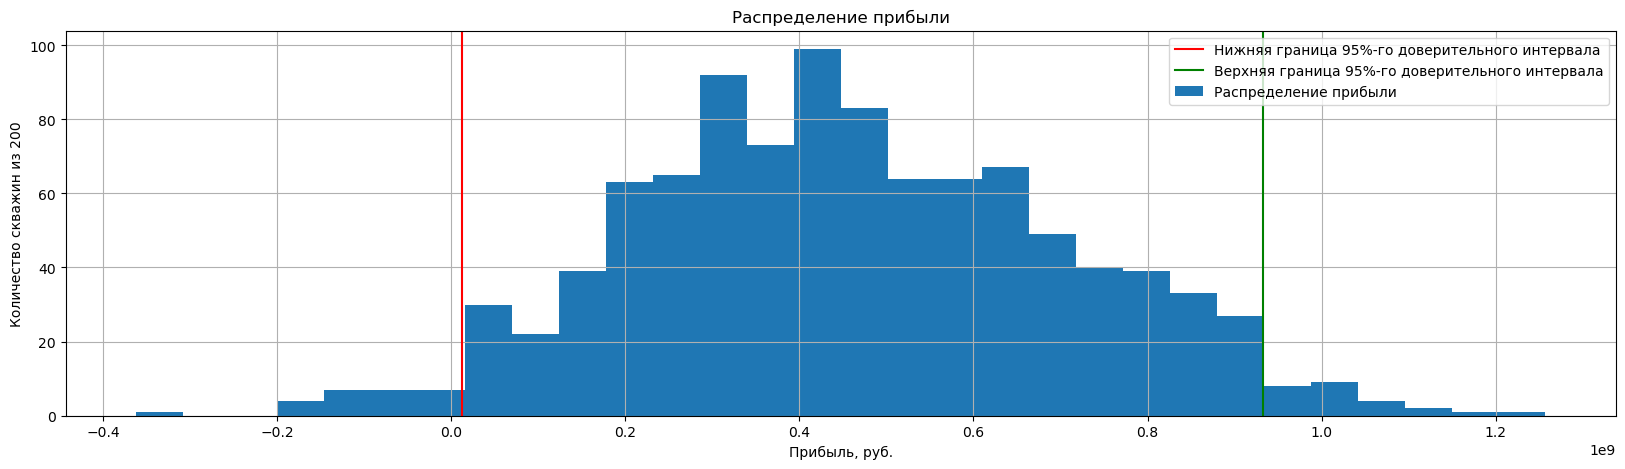

In [41]:
bootstrap(target_valid_reg_00, predicted_reg_00)

95% доверительный интервал:    20.99 млн. руб. -  835.91 млн. руб.
Средняя прибыль:   432.60 млн. руб.
Риск убытка: 2.0%


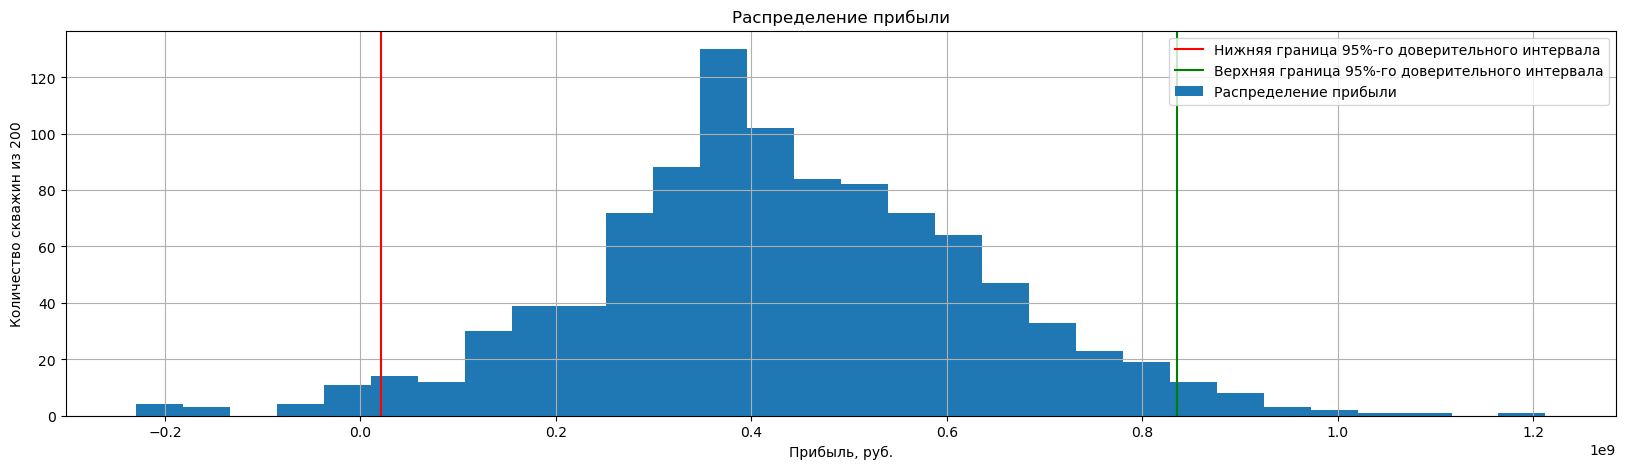

In [42]:
bootstrap(target_valid_reg_01, predicted_reg_01)

95% доверительный интервал:  -103.90 млн. руб. -  900.10 млн. руб.
Средняя прибыль:   394.86 млн. руб.
Риск убытка: 7.1%


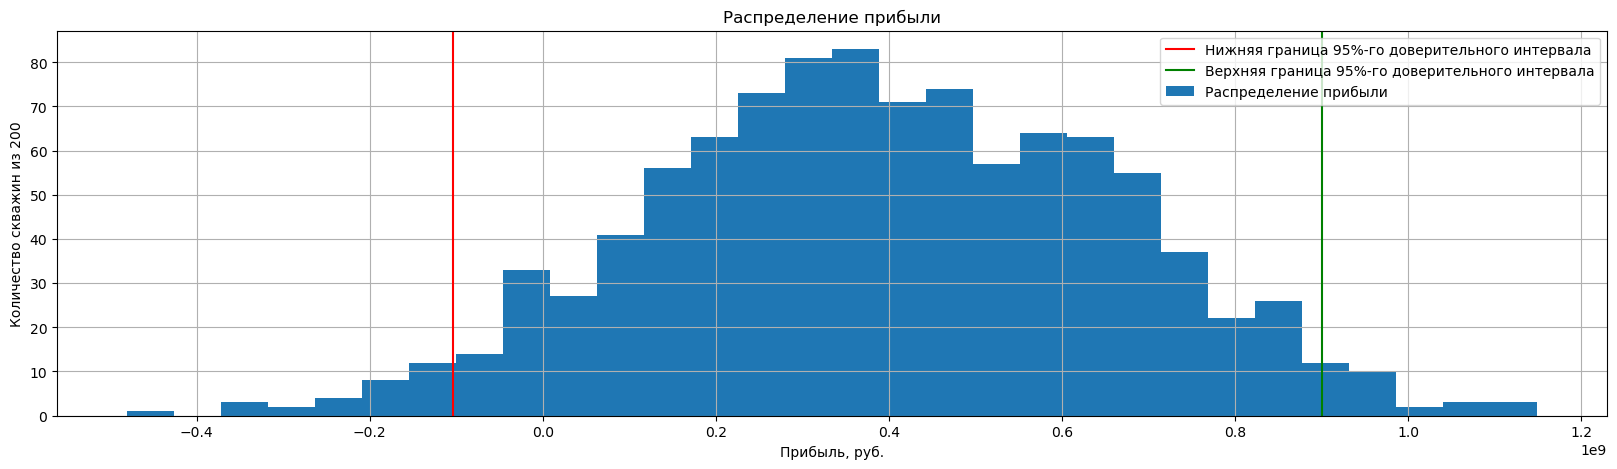

In [43]:
bootstrap(target_valid_reg_02, predicted_reg_02)

## Вывод

В ходе выполнения работы были выполнены следующие мероприятия:
1. Загружены данные для трех регионов исследования
2. Изучены данные, был исключен малоинформативный столбец 'id'
3. Подготовлены данные (разбиты в соотношении 75:25), обучена модель с выводом среднего запаса предсказанного сырья и RMSE модели.
4. Написана функция подсчета прибыли, а также были сохранены константы в переменные
5. Были определены 200 скважин с наилучшими результатами, подсчитана максимальная прибыль.
6. Использовали Bootstrap с 1000 выборки, для определения возможного распределения прибыли, средней прибылью, а также вероятностью убытка.

## Вывод по цели исследования

Наилучшими показателями обладает регион №1 (geo_data_1) со следующими параметрами:
1. 95% доверительный интервал:    45.28 млн. руб. -  840.86 млн. руб.
2. Средняя прибыль:   438.83 млн. руб.
3. Риск убытка: 1.2%

Из всех рассмотренных регионов, только этот регион имеет риски убытка ниже заданных.

Вместе с тем, следует отметить следующие факторы:
1. Подозрительное распределение данных (консолидация вокруг определенных значений, без разбросов)
2. 100% корреляция между 'product' и 'f2'.
3. При всех пунктах, он имеет наименьший средний предсказанный запас.

В соответствии с вышесказанным, при условиях повторной проверки корректности данных по региону №1, он является единственным, подходящим под условия задачи.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [X]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [X]  Выполнен шаг 1: данные подготовлены
- [X]  Выполнен шаг 2: модели обучены и проверены
    - [X]  Данные корректно разбиты на обучающую и валидационную выборки
    - [X]  Модели обучены, предсказания сделаны
    - [X]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [X]  На экране напечатаны результаты
    - [X]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [X]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [X]  По предыдущему пункту сделаны выводы
    - [X]  Написана функция расчёта прибыли
- [X]  Выполнен шаг 4: посчитаны риски и прибыль
    - [X]  Проведена процедура *Bootstrap*
    - [X]  Все параметры бутстрепа соответствуют условию
    - [X]  Найдены все нужные величины
    - [X]  Предложен регион для разработки месторождения
    - [X]  Выбор региона обоснован